In [79]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df_messages = pd.read_csv('train_spam.csv', index_col=None)

df_messages.groupby('text_type').count()

,text
text_type,
ham,11469
spam,4809


In [81]:
import re
import emoji
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import fasttext

import numpy as np

class SpamFilter:
    def __init__(self):
        self.estimators = []
        self.stop_words = set(stopwords.words('english'))

    def text_preprocessing(self, raw_text):
        # 1. Deleting unnecessary information
        # 1.1. HTML-tags
        pure_text = re.sub(r'<[^<]+?>', '', raw_text)
        # 1.2. Links
        pure_text = re.sub(r'http\S+', '', pure_text)
        # 1.3. Social media tags
        pure_text = re.sub(r'@\S+', '', pure_text)
        
        # 2. Replacing special characters
        # 2.1. Converting emoji to text description
        pure_text = emoji.demojize(pure_text, delimiters=(" ", " ")).replace("_", " ")
        # 2.2. Replacing diacritics with ASCII characters and converting to 'UTF-8'
        pure_text = unicodedata.normalize('NFKD', pure_text)
        pure_text.encode('ascii', 'ignore').decode('utf-8', 'ignore')
        
        # 3. Deleting non-(letters/punctuation marks/whitespaces)
        pure_text = re.sub(r"[^a-zA-Z'\s]", '', pure_text)
        
        # 4. Replacing sequens of whitespaces
        pure_text = re.sub('\s+', ' ', pure_text)
        
        # 5. Converting to lowercase
        pure_text = pure_text.lower()
        
        # 6. Removing stop-wodrs
        tokens = word_tokenize(pure_text)
        tokens = [token for token in tokens if token not in self.stop_words]
        clean_text = ' '.join(tokens)

        return pure_text

    def fit(self, messages, labels):
        with open('train.txt', 'w') as f:
            for lbl, mssg in zip(labels, messages):
                f.writelines(f"__label__{lbl} {self.text_preprocessing(mssg)}\n")
        self.estimators.append(fasttext.train_supervised('train.txt'))
        self.estimators.append(fasttext.train_supervised('train.txt', wordNgrams=2, epoch=10))
        self.estimators.append(fasttext.train_supervised('train.txt', wordNgrams=3, epoch=15))
    
    def predict(self, messages):
        predictions = []
        probabilities = self.predict_proba(messages)
        for prob in probabilities:
            pred = 'ham' if prob[0] > prob[1] else 'spam'
            predictions.append(pred)
        return np.array(predictions)
    
    @staticmethod
    def output_processor(pred):
        probabilities = None
        # fasttext.predict() output: ( ('most probable label',), array(['it's probability]) )
        lbl = pred[0][0]
        prob = pred[1][0]
        # Иногда fasttext возвращает вероятность чуть большую единицы
        prob = prob if prob <= 1.0 else 1.0
        if lbl == '__label__ham':
            probabilities = [prob, 1 - prob]
        else:
            probabilities = [1 - prob, prob]
        return probabilities

    def predict_proba(self, messages):
        probabilities = []
        for mssg in messages:
            probs = []
            for est in self.estimators:
                probs.append( self.output_processor(est.predict(self.text_preprocessing(mssg))) )
            probs = np.array(probs)
            probabilities.append([np.mean(probs[:,0]), np.mean(probs[:,1])])
        return np.array(probabilities)

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_messages, test_size = 0.2, random_state=16)

SF = SpamFilter()
SF.fit(train['text'], train['text_type'])

Read 0M words
Number of words:  37608
Number of labels: 2
Progress: 100.0% words/sec/thread: 2595563 lr:  0.000000 avg.loss:  0.156205 ETA:   0h 0m 0s
Read 0M words
Number of words:  37608
Number of labels: 2
Progress: 100.0% words/sec/thread: 1995296 lr:  0.000000 avg.loss:  0.051862 ETA:   0h 0m 0s
Read 0M words
Number of words:  37608
Number of labels: 2
Progress: 100.0% words/sec/thread: 1179806 lr:  0.000000 avg.loss:  0.021369 ETA:   0h 0m 0s


0.9164149043303121
0.9090909090909091
0.9127382146439318
0.982442834327535


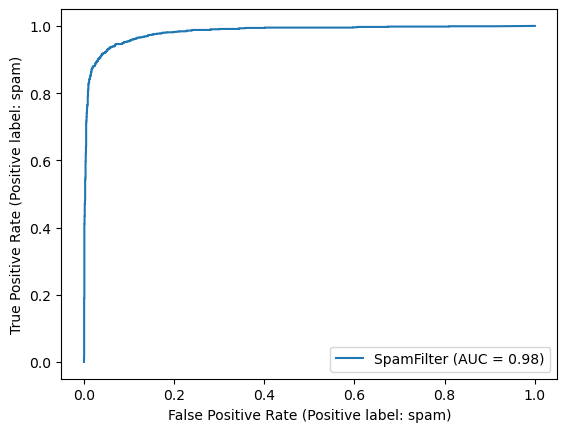

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, RocCurveDisplay, roc_auc_score

predictions = SF.predict(test['text'])
probabilities = SF.predict_proba(test['text'])

RocCurveDisplay.from_predictions(test['text_type'], probabilities[:,1], pos_label='spam', name='SpamFilter')


print(precision_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam'))
print(recall_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam'))
print(f1_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam'))
print(roc_auc_score(test['text_type'], probabilities[:,1]))

In [83]:
from sklearn.model_selection import KFold

for i in range(5):
    kf = KFold(n_splits=5, shuffle=True)
    results = []
    for train_index, test_index in kf.split(df_messages):
        train = df_messages.iloc[train_index]
        test = df_messages.iloc[test_index]
        
        SF = SpamFilter()
        SF.fit(train['text'], train['text_type'])
        
        predictions = SF.predict(test['text'])
        probabilities = SF.predict_proba(test['text'])
        
        pr = precision_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam')
        rc = recall_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam')
        f1 = f1_score(test['text_type'], predictions, labels=['ham', 'spam'], pos_label='spam')
        roc_auc = roc_auc_score(test['text_type'], probabilities[:,1])
        
        results.append([pr, rc, f1, roc_auc])
        
    results = pd.DataFrame(results, columns=['precision', 'recall', 'f1', 'roc_auc'])
    display(results)
    print(results.mean())

Read 0M words
Number of words:  37739
Number of labels: 2
Progress: 100.0% words/sec/thread: 2558075 lr:  0.000000 avg.loss:  0.166660 ETA:   0h 0m 0s
Read 0M words
Number of words:  37739
Number of labels: 2
Progress: 100.0% words/sec/thread: 1294599 lr:  0.000000 avg.loss:  0.109986 ETA:   0h 0m 0s
Read 0M words
Number of words:  37739
Number of labels: 2
Progress: 100.0% words/sec/thread:  861753 lr:  0.000000 avg.loss:  0.092441 ETA:   0h 0m 0s
Read 0M words
Number of words:  37677
Number of labels: 2
Progress: 100.0% words/sec/thread: 2567771 lr:  0.000000 avg.loss:  0.168364 ETA:   0h 0m 0s
Read 0M words
Number of words:  37677
Number of labels: 2
Progress: 100.0% words/sec/thread: 1735245 lr:  0.000000 avg.loss:  0.109588 ETA:   0h 0m 0s
Read 0M words
Number of words:  37677
Number of labels: 2
Progress: 100.0% words/sec/thread: 1116575 lr:  0.000000 avg.loss:  0.094446 ETA:   0h 0m 0s0m 0s
Read 0M words
Number of words:  37841
Number of labels: 2
Progress: 100.0% words/sec/thre

,precision,recall,f1,roc_auc
0,0.952695,0.903967,0.927691,0.987209
1,0.924211,0.901437,0.912682,0.984326
2,0.929901,0.905117,0.917342,0.982937
3,0.956568,0.918616,0.937208,0.987695
4,0.934409,0.908996,0.921527,0.982294


precision    0.939557
recall       0.907627
f1           0.923290
roc_auc      0.984892
dtype: float64


Read 0M words
Number of words:  37508
Number of labels: 2
Progress: 100.0% words/sec/thread: 2582782 lr:  0.000000 avg.loss:  0.173199 ETA:   0h 0m 0s
Read 0M words
Number of words:  37508
Number of labels: 2
Progress: 100.0% words/sec/thread: 1705395 lr:  0.000000 avg.loss:  0.110603 ETA:   0h 0m 0s
Read 0M words
Number of words:  37508
Number of labels: 2
Progress: 100.0% words/sec/thread: 1110594 lr:  0.000000 avg.loss:  0.092039 ETA:   0h 0m 0s
Read 0M words
Number of words:  37562
Number of labels: 2
Progress: 100.0% words/sec/thread: 2549734 lr:  0.000000 avg.loss:  0.158916 ETA:   0h 0m 0s
Read 0M words
Number of words:  37562
Number of labels: 2
Progress: 100.0% words/sec/thread: 2027251 lr:  0.000000 avg.loss:  0.107441 ETA:   0h 0m 0s
Read 0M words
Number of words:  37562
Number of labels: 2
Progress: 100.0% words/sec/thread:  848238 lr:  0.000000 avg.loss:  0.092544 ETA:   0h 0m 0s
Read 0M words
Number of words:  37634
Number of labels: 2
Progress: 100.0% words/sec/thread: 2

,precision,recall,f1,roc_auc
0,0.940741,0.915551,0.927975,0.986213
1,0.937290,0.916758,0.926910,0.983707
2,0.953927,0.901980,0.927226,0.984175
3,0.938232,0.904517,0.921066,0.985709
4,0.937500,0.908608,0.922828,0.981573


precision    0.941538
recall       0.909483
f1           0.925201
roc_auc      0.984275
dtype: float64


Read 0M words
Number of words:  37591
Number of labels: 2
Progress: 100.0% words/sec/thread: 2544320 lr:  0.000000 avg.loss:  0.165567 ETA:   0h 0m 0s
Read 0M words
Number of words:  37591
Number of labels: 2
Progress: 100.0% words/sec/thread: 1737259 lr:  0.000000 avg.loss:  0.105819 ETA:   0h 0m 0s
Read 0M words
Number of words:  37591
Number of labels: 2
Progress: 100.0% words/sec/thread: 1030396 lr:  0.000000 avg.loss:  0.092022 ETA:   0h 0m 0s
Read 0M words
Number of words:  38011
Number of labels: 2
Progress: 100.0% words/sec/thread: 2599220 lr:  0.000000 avg.loss:  0.163780 ETA:   0h 0m 0s
Read 0M words
Number of words:  38011
Number of labels: 2
Progress: 100.0% words/sec/thread: 1724693 lr:  0.000000 avg.loss:  0.106946 ETA:   0h 0m 0s
Read 0M words
Number of words:  38011
Number of labels: 2
Progress: 100.0% words/sec/thread: 1036608 lr:  0.000000 avg.loss:  0.094186 ETA:   0h 0m 0s
Read 0M words
Number of words:  37433
Number of labels: 2
Progress: 100.0% words/sec/thread: 2

,precision,recall,f1,roc_auc
0,0.947137,0.909091,0.927724,0.984030
1,0.930890,0.899798,0.915080,0.982806
2,0.958242,0.906445,0.931624,0.984243
3,0.931290,0.900818,0.915800,0.985893
4,0.929501,0.916578,0.922994,0.984646


precision    0.939412
recall       0.906546
f1           0.922644
roc_auc      0.984324
dtype: float64


Read 0M words
Number of words:  37368
Number of labels: 2
Progress: 100.0% words/sec/thread: 2565500 lr:  0.000000 avg.loss:  0.169108 ETA:   0h 0m 0s
Read 0M words
Number of words:  37368
Number of labels: 2
Progress: 100.0% words/sec/thread: 1730788 lr:  0.000000 avg.loss:  0.104460 ETA:   0h 0m 0s
Read 0M words
Number of words:  37368
Number of labels: 2
Progress: 100.0% words/sec/thread: 1021420 lr:  0.000000 avg.loss:  0.087346 ETA:   0h 0m 0s
Read 0M words
Number of words:  37790
Number of labels: 2
Progress: 100.0% words/sec/thread: 2616769 lr:  0.000000 avg.loss:  0.170807 ETA:   0h 0m 0s
Read 0M words
Number of words:  37790
Number of labels: 2
Progress: 100.0% words/sec/thread: 2026614 lr:  0.000000 avg.loss:  0.112103 ETA:   0h 0m 0s
Read 0M words
Number of words:  37790
Number of labels: 2
Progress: 100.0% words/sec/thread: 1116422 lr:  0.000000 avg.loss:  0.094896 ETA:   0h 0m 0s
Read 0M words
Number of words:  37847
Number of labels: 2
Progress: 100.0% words/sec/thread: 2

,precision,recall,f1,roc_auc
0,0.951404,0.891700,0.920585,0.983122
1,0.946225,0.904150,0.924709,0.985413
2,0.929117,0.897787,0.913183,0.984533
3,0.932112,0.921193,0.926620,0.983218
4,0.914317,0.915309,0.914813,0.985733


precision    0.934635
recall       0.906028
f1           0.919982
roc_auc      0.984404
dtype: float64


Read 0M words
Number of words:  37679
Number of labels: 2
Progress: 100.0% words/sec/thread: 2550657 lr:  0.000000 avg.loss:  0.168451 ETA:   0h 0m 0s
Read 0M words
Number of words:  37679
Number of labels: 2
Progress: 100.0% words/sec/thread: 1724521 lr:  0.000000 avg.loss:  0.110869 ETA:   0h 0m 0s
Read 0M words
Number of words:  37679
Number of labels: 2
Progress: 100.0% words/sec/thread: 1113162 lr:  0.000000 avg.loss:  0.094273 ETA:   0h 0m 0s
Read 0M words
Number of words:  37505
Number of labels: 2
Progress: 100.0% words/sec/thread: 2569452 lr:  0.000000 avg.loss:  0.173608 ETA:   0h 0m 0s
Read 0M words
Number of words:  37505
Number of labels: 2
Progress: 100.0% words/sec/thread: 1739591 lr:  0.000000 avg.loss:  0.109559 ETA:   0h 0m 0s
Read 0M words
Number of words:  37505
Number of labels: 2
Progress: 100.0% words/sec/thread: 1105126 lr:  0.000000 avg.loss:  0.095699 ETA:   0h 0m 0s
Read 0M words
Number of words:  37835
Number of labels: 2
Progress: 100.0% words/sec/thread: 2

,precision,recall,f1,roc_auc
0,0.926882,0.888660,0.907368,0.981567
1,0.944385,0.917879,0.930944,0.988584
2,0.934641,0.905063,0.919614,0.987424
3,0.936264,0.925081,0.930639,0.985430
4,0.951782,0.900794,0.925586,0.982212


precision    0.938791
recall       0.907496
f1           0.922830
roc_auc      0.985043
dtype: float64
